In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [135]:
nfl_sched_2024 = pd.read_excel('nfl_2024_schedule.xlsx')
nfl_sched_2024

,Week,Seasonweek,Winner,Loser,Home Team,Away Team
0,1,202401,KAN,RAV,KAN,RAV
1,1,202401,PHI,GNB,PHI,GNB
2,1,202401,PIT,ATL,ATL,PIT
3,1,202401,BUF,CRD,BUF,CRD
4,1,202401,NOR,CAR,NOR,CAR
...,...,...,...,...,...,...
267,18,202418,DEN,KAN,DEN,KAN
268,18,202418,NYJ,MIA,NYJ,MIA
269,18,202418,SDG,RAI,RAI,SDG
270,18,202418,SEA,RAM,RAM,SEA


In [122]:
games = []
for _, row in nfl_sched_2024.iterrows():
    games.append({
        'week': int(row['Seasonweek']),
        'away': row['Away Team'],
        'home': row['Home Team'],
        'winner': row['Winner']
    })

In [123]:
games_formatted = []

for g in games:
    games_formatted.append({
        'week': g['week'],
        'team_a': g['away'],  # Always away team
        'team_b': g['home'],  # Always home team
        'winner': g['winner']
    })

In [136]:
# Load embeddings
gru_embedding_df = pd.read_csv('gru_team_embeddings_by_week.csv')
mlp_embedding_df = pd.read_csv('mlp_2023_2024_embeddings.csv')
mlp_embedding_df.set_index('team', inplace=True)

In [137]:
def build_interaction_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [138]:
def get_gru_embedding(team, seasonweek, df, embedding_cols):
    row = df[(df['team'] == team) & (df['seasonweek'] == seasonweek)]
    if row.empty:
        raise KeyError(f"No GRU embedding for {team} at week {seasonweek}")
    return row[embedding_cols].values[0]

In [139]:
def get_previous_week(current_week, all_weeks):
    season, week = divmod(current_week, 100)
    prev_week = (season - 1) * 100 + 18 if week == 1 else season * 100 + (week - 1)
    return prev_week if prev_week in all_weeks else None

In [140]:
embedding_cols = [col for col in gru_embedding_df.columns if col.startswith('emb_')]
gru_dim = len(embedding_cols)
mlp_dim = mlp_embedding_df.shape[1]
input_dim = 2 * (gru_dim + mlp_dim)

print(f"GRU embedding dim: {gru_dim}")
print(f"MLP embedding dim: {mlp_dim}")
print(f"Total input dimension: {input_dim}")

GRU embedding dim: 16
MLP embedding dim: 32
Total input dimension: 96


In [141]:
interaction_model = build_interaction_model(input_dim)

C:\Users\danbi\nflvenv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [142]:
all_weeks = sorted(set(game['week'] for game in games_formatted))

In [143]:
window_size = 2
all_train_losses, all_train_accuracies, all_weeks_trained = [], [], []

for i in range(window_size - 1, len(all_weeks)):
    weeks_to_train = all_weeks[i - window_size + 1: i + 1]
    print(f"\n🚂 Training window: {weeks_to_train}")

    X, y = [], []
    for g in games_formatted:
        if g['week'] not in weeks_to_train:
            continue

        t1, t2 = g['team_a'], g['team_b']
        try:
            gru_a = get_gru_embedding(t1, g['week'], gru_embedding_df, embedding_cols).flatten()
            gru_b = get_gru_embedding(t2, g['week'], gru_embedding_df, embedding_cols).flatten()
            mlp_a = mlp_embedding_df.loc[t1].values.flatten()
            mlp_b = mlp_embedding_df.loc[t2].values.flatten()
        except Exception as e:
            print(f"  ❌ skipping {t1} vs {t2} (wk {g['week']}): {e}")
            continue

        input_vec = np.concatenate([gru_a, mlp_a, gru_b, mlp_b])
        X.append(input_vec)
        y.append(1 if g['winner'] == t1 else 0)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    print(f"  ▶ {X.shape[0]} games, input shape {X.shape}")
    if X.shape[0] == 0:
        print("  ‼️ No games to train on")
        continue

    history = interaction_model.fit(X, y, epochs=20, batch_size=16, verbose=0)
    all_train_losses.append(history.history['loss'][-1])
    all_train_accuracies.append(history.history['accuracy'][-1])
    all_weeks_trained.append(all_weeks[i])



🚂 Training window: [202401, 202402]
  ▶ 32 games, input shape (32, 96)

🚂 Training window: [202402, 202403]
  ▶ 32 games, input shape (32, 96)

🚂 Training window: [202403, 202404]
  ▶ 32 games, input shape (32, 96)

🚂 Training window: [202404, 202405]
  ▶ 30 games, input shape (30, 96)

🚂 Training window: [202405, 202406]
  ▶ 28 games, input shape (28, 96)

🚂 Training window: [202406, 202407]
  ▶ 29 games, input shape (29, 96)

🚂 Training window: [202407, 202408]
  ▶ 31 games, input shape (31, 96)

🚂 Training window: [202408, 202409]
  ▶ 31 games, input shape (31, 96)

🚂 Training window: [202409, 202410]
  ▶ 29 games, input shape (29, 96)

🚂 Training window: [202410, 202411]
  ▶ 28 games, input shape (28, 96)

🚂 Training window: [202411, 202412]
  ▶ 27 games, input shape (27, 96)

🚂 Training window: [202412, 202413]
  ▶ 29 games, input shape (29, 96)

🚂 Training window: [202413, 202414]
  ▶ 29 games, input shape (29, 96)

🚂 Training window: [202414, 202415]
  ▶ 29 games, input shape (

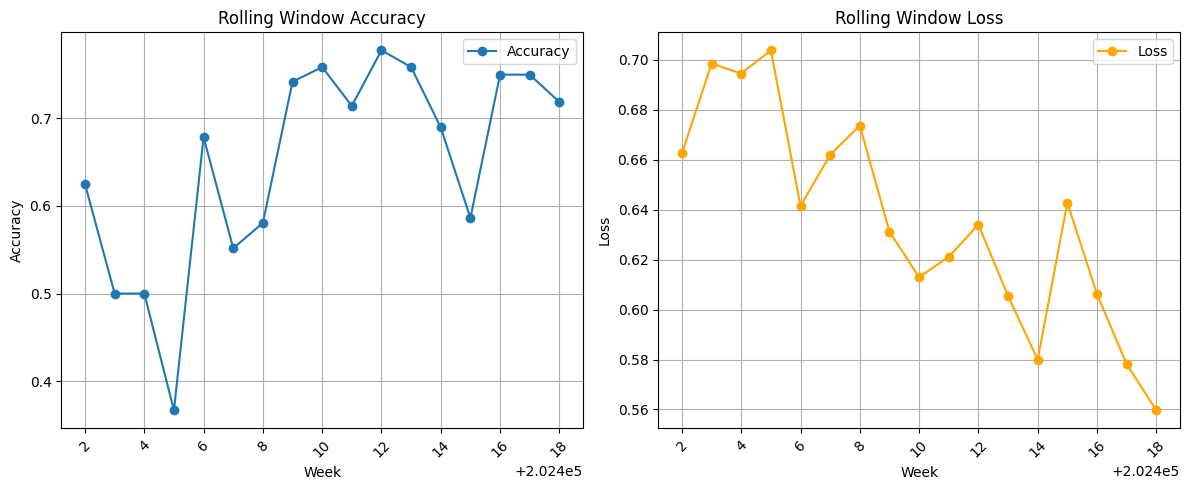

In [144]:
def plot_rolling_window_training(weeks, losses, accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(weeks, accuracies, marker='o', label='Accuracy')
    plt.xlabel("Week")
    plt.ylabel("Accuracy")
    plt.title("Rolling Window Accuracy")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(weeks, losses, marker='o', color='orange', label='Loss')
    plt.xlabel("Week")
    plt.ylabel("Loss")
    plt.title("Rolling Window Loss")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_rolling_window_training(all_weeks_trained, all_train_losses, all_train_accuracies)

In [145]:
def predict_game(team_a, team_b, week, interaction_model, mlp_embeddings, gru_embedding_df, embedding_cols, all_weeks_sorted):
    prev_week = get_previous_week(week, all_weeks_sorted)

    def get_gru(team, seasonweek):
        row = gru_embedding_df[(gru_embedding_df['team'] == team) & (gru_embedding_df['seasonweek'] == seasonweek)]
        if row.empty:
            raise ValueError(f"No GRU embedding found for team {team} at week {seasonweek}")
        return row[embedding_cols].values[0]

    try:
        t1_gru = get_gru(team_a, prev_week)
        t2_gru = get_gru(team_b, prev_week)
        t1_mlp = mlp_embeddings[team_a].squeeze()
        t2_mlp = mlp_embeddings[team_b].squeeze()
    except Exception as e:
        print(f"Embedding error: {e}")
        return None

    input_vector = np.concatenate([t1_gru, t1_mlp, t2_gru, t2_mlp]).reshape(1, -1)
    prob_team_a_wins = interaction_model.predict(input_vector)[0][0]
    predicted_winner = team_a if prob_team_a_wins >= 0.5 else team_b

    print(f"{team_a} vs {team_b} (Week {week}) → {team_a} win prob: {prob_team_a_wins:.4f}")
    print(f"🟩 Predicted winner: {predicted_winner}")
    return prob_team_a_wins, predicted_winner

In [146]:
# Example game
predict_game('CLT', 'GNB', 202402, interaction_model, mlp_embeddings, gru_embedding_df, embedding_cols, all_weeks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
CLT vs GNB (Week 202402) → CLT win prob: 0.2241
🟩 Predicted winner: GNB


(np.float32(0.22412518), 'GNB')

In [147]:
predict_game('CHI', 'HTX', 202402, interaction_model, mlp_embeddings, gru_embedding_df, embedding_cols, all_weeks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
CHI vs HTX (Week 202402) → CHI win prob: 0.2749
🟩 Predicted winner: HTX


(np.float32(0.27487305), 'HTX')

In [148]:
predict_game('PIT', 'DEN', 202402, interaction_model, mlp_embeddings, gru_embedding_df, embedding_cols, all_weeks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PIT vs DEN (Week 202402) → PIT win prob: 0.5733
🟩 Predicted winner: PIT


(np.float32(0.57326555), 'PIT')

In [149]:
predict_game('NYG', 'WAS', 202402, interaction_model, mlp_embeddings, gru_embedding_df, embedding_cols, all_weeks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
NYG vs WAS (Week 202402) → NYG win prob: 0.2432
🟩 Predicted winner: WAS


(np.float32(0.24320133), 'WAS')

In [150]:
predict_game('CLE', 'JAX', 202402, interaction_model, mlp_embeddings, gru_embedding_df, embedding_cols, all_weeks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
CLE vs JAX (Week 202402) → CLE win prob: 0.1744
🟩 Predicted winner: JAX


(np.float32(0.1744237), 'JAX')

In [151]:
# Save the trained interaction model
interaction_model.save('interaction_model_rolling_window.keras')